<a href="https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/create_graphic_icecore_back_10K_keelingcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a graphic appearing on the Keeling Curve website
### **Graphic: CO<sub>2</sub> record from 10K years ago to now**

**Mauna Loa, Hawaii CO<sub>2</sub> record starting in 1958 and ice-core CO<sub>2</sub> record before 1958**

#### This notebook creates customizable PDF and PNG images of a graphic appearing on the front page of [https://keelingcurve.ucsd.edu](keelingcurve.ucsd.edu).

See an overview of the Keeling Curve notebooks at [notebooks overview](https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/overview_of_notebooks_keelingcurve.ipynb)

#### Sample of the graphic produced by this notebook

![title](https://github.com/sio-co2o2/keelingcurve_notebooks/blob/main/images/sample_plots/co2_10k.png?raw=1)

## **Notebook Code**

### Import packages

In [1]:
import requests
import re
import pandas as pd
import numpy as np
from scipy import interpolate
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
from matplotlib import rc,rcParams
from matplotlib.path import Path
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.transforms
from matplotlib import animation
from ipywidgets import widgets
from IPython.display import HTML, display
from base64 import b64encode
from PIL import Image
import urllib
import os

%matplotlib inline

In [2]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg

In [3]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

### Set directories and file names

In [4]:
# Get MLO data from the keelingcurve_notebooks github repository
mlo_data_file = 'https://raw.githubusercontent.com/sio-co2o2/keelingcurve_notebooks/main/data/mlo/mlo_full_record_now_span.csv'

# Get the icecore dataset back 2K years located at
# the site: https://www.ncei.noaa.gov/access/paleo-search/study/9959
# the file: https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt
# with a reference to the journal article at https://doi.org/10.1029/2006GL026152
icecore_2K_url = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt'

# Get the icecore dataset back 800K years located at 
# the site: https://www.ncei.noaa.gov/access/paleo-search/study/6091
# the file: https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-co2-2008.txt
# with a reference to the journal articls at https://doi.org/10.1038/nature06949
icecore_800K_url = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-co2-2008.txt'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/ucsd_sio_logo.svg'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_basename = 'co2_10k'

pdf_file = plot_dir / f"{plot_basename}.pdf"
png_file = plot_dir / f"{plot_basename}.png"

## **Define accessory functions needed to prepare data for plotting**

## Functions to convert dates into various formats

In [5]:
# Function to convert datetime to a float

# source, https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [6]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

## **Load in data and prepare it for plotting**

### Load in MLO record

In [7]:
df_mlo = pd.read_csv(mlo_data_file,sep=',',comment='"')
df_mlo.head()

,date,co2,date_seas_adj,co2_seas_adj,date_fit,co2_fit,date_seas_adj_fit,co2_seas_adj_fit,date_filled,co2_filled,date_seas_adj_filled,co2_seas_adj_filled
0,1958.202740,315.71,1958.202740,314.43,1958.202740,316.20,1958.202740,314.91,1958.202740,315.71,1958.202740,314.43
1,1958.287671,317.45,1958.287671,315.16,1958.287671,317.30,1958.287671,314.99,1958.287671,317.45,1958.287671,315.16
2,1958.369863,317.51,1958.369863,314.70,1958.369863,317.88,1958.369863,315.06,1958.369863,317.51,1958.369863,314.70
3,1958.536986,315.87,1958.536986,315.20,1958.454795,317.26,1958.454795,315.14,1958.454795,317.26,1958.454795,315.14
4,1958.621918,314.93,1958.621918,316.21,1958.536986,315.85,1958.536986,315.22,1958.536986,315.87,1958.536986,315.20


### Get MLO seasonally adjusted data

In [8]:
df_mlo = df_mlo[['date_seas_adj', 'co2_seas_adj']].copy()

### Remove rows with fill values NaN

In [9]:
df_mlo = df_mlo.dropna()

### Convert to numpy arrays for plotting.

Will use this to annotate the plot at various years

In [10]:
mlo_date = df_mlo['date_seas_adj'].to_numpy()
mlo_co2 = df_mlo['co2_seas_adj'].to_numpy()

### Load in the icecore record back 2K years

In [11]:
response = requests.get(icecore_2K_url)
file_text = response.text
text_lines = file_text.split('\n')

#### Use data from section 2 of the ice-core file law2006.txt labeled: "CO2 by Core"

**Section to start with**

2\. CO2 by Core 

Gas age, Year AD 

SampleType   CO2gasAge  CO2(ppm)  Publication status


**Section to stop at**

3\. CO2 by Age 

In [12]:
start_section = [i for i in range(len(text_lines))
               if text_lines[i].startswith('2. CO2 by Core')][0]

end_section = [i for i in range(len(text_lines))
             if text_lines[i].startswith('3. CO2 by Age ')][0]

section_lines = text_lines[start_section: end_section]

# start data selection after line "SampleType   CO2gasAge  CO2(ppm)  Publication status"
header_end = [i for i in range(len(section_lines))
              if section_lines[i].startswith('SampleType')][0]

start_data = header_end + 1

data_lines = section_lines[start_data: end_section]

data_lines[1:10]

['DSS            1036.8    280.3    Eth et al., 1996',
 'DSS            1087.5    282.4    Eth et al., 1996',
 'DSS            1136.8    283.8    Eth et al., 1996',
 'DSS            1192.6    283.9    Eth et al., 1996',
 'DSS            1246.3    281.7    Eth et al., 1996',
 'DSS            1330.1    283.4    Eth et al., 1996',
 'DSS            1390.5    280.4    Eth et al., 1996',
 'DSS            1390.5    280.0    Eth et al., 1996',
 'DSS            1449.1    281.7    Eth et al., 1996']

#### Filter data

Further exclude sample types: DSSW20K firn and CAPE GRIM

Keep sample types: DSS, DE08, and DE08-2

In [13]:
filtered_data_lines = []

for line in data_lines:

    # Don't include empty lines
    if not line:
        continue

    if "DSSW20K firn" in line or "CAPE GRIM" in line:
        continue
    else:
        filtered_data_lines.append(line)

Remove Publication status from lines

In [14]:
r = re.compile('(.+\d+.*\d+.*\d)\s.*')

filtered_list = [m.group(1) for m in (r.match(line) for line in filtered_data_lines) if m]

Remove SampleType from lines

In [15]:
r = re.compile('.+\s+(\d.*\s+\d.*)')

data_list = [m.group(1) for m in (r.match(line)
                                      for line in filtered_list) if m]

Read data list into a Pandas dataframe and split into columns year and co2

In [16]:
df_icecore_2K = pd.DataFrame(data_list)
df_icecore_2K.columns = ['data']

df_icecore_2K[['date_ce', 'co2']] = df_icecore_2K['data'].str.split(" ", 1, expand=True)
df_icecore_2K.drop('data', axis=1, inplace=True)

df_icecore_2K.head()

,date_ce,co2
0,1005.0,279.4
1,1036.8,280.3
2,1087.5,282.4
3,1136.8,283.8
4,1192.6,283.9


Convert columns from strings to numbers

In [17]:
df_icecore_2K = df_icecore_2K.astype(float)

Sort from lowest to highest year


In [18]:
df_icecore_2K = df_icecore_2K.sort_values(by=['date_ce'], ascending=True)

# And reset the index
df_icecore_2K = df_icecore_2K.reset_index(drop=True)

df_icecore_2K.head()

,date_ce,co2
0,13.3,276.7
1,29.5,277.9
2,56.0,277.4
3,104.5,277.5
4,136.0,278.1


Filter out icecore data past 1957 when MLO data starts

In [19]:
df_icecore_2K = df_icecore_2K[df_icecore_2K['date_ce'] <= 1957]

### Load in the icecore record back 800K years
The date column is in BP units which stands for "before present year"


In [20]:
response = requests.get(icecore_800K_url)
file_text = response.text
text_lines = file_text.split('\n')

#### Use data from section 3 of ice-core file edc-co2-2008.txt labeled: "Composite CO2 record"

**Section to start with**

3. Composite CO2 record (0-800 kyr BP)

**Section to stop with**

end of file

In [21]:
start_section = [i for i in range(len(text_lines))
               if text_lines[i].startswith('3. Composite CO2 record (0-800 kyr BP)')][0]

# Select to end of file since no more sections after Section 3
section_lines = text_lines[start_section:]

# start data selection after line "Age(yrBP)    CO2(ppmv)"
header_end = [i for i in range(len(section_lines))
              if section_lines[i].startswith('Age(yrBP)')][0]

start_data = header_end + 1

data_lines = section_lines[start_data:]

data_lines[1:10]

['268           274.9\r',
 '279           277.9\r',
 '395           279.1\r',
 '404           281.9\r',
 '485           277.7\r',
 '559           281.1\r',
 '672           282.2\r',
 '754           280.1\r',
 '877           278.4\r']

Remove trailing return character

In [22]:
data_list = [line.rstrip() for line in data_lines]
data_list[0:10]

['137           280.4',
 '268           274.9',
 '279           277.9',
 '395           279.1',
 '404           281.9',
 '485           277.7',
 '559           281.1',
 '672           282.2',
 '754           280.1',
 '877           278.4']

Read data list into a Pandas dataframe and split into columns date_ce and co2

In [23]:
df_icecore_800K = pd.DataFrame(data_list)
df_icecore_800K.columns = ['data']

df_icecore_800K[['date_bp', 'co2']] = df_icecore_800K['data'].str.split(" ", 1, expand=True)
df_icecore_800K.drop('data', axis=1, inplace=True)

df_icecore_800K.head()

,date_bp,co2
0,137,280.4
1,268,274.9
2,279,277.9
3,395,279.1
4,404,281.9


Remove empty rows and convert columns from strings to numbers

In [24]:
# First change empty strings to NaN. Then can easily drop NaN rows
df_icecore_800K['date_bp'].replace('', np.nan, inplace=True)

df_icecore_800K = df_icecore_800K.dropna()

df_icecore_800K = df_icecore_800K.astype(float)

### Combine 800K back and 2K back together
Exclude 800K dataset points that overlap with the start of the 2K dataset

The date in the 800K dataset is in BP years which means (before present) years. Here in the dataset, present year is 1950

First convert 800K dataset from dates BP (before present) to CE

years before present = 1950 - year ce

year ce = 1950 - years before present

In [25]:
df_icecore_800K['date_ce'] = 1950 - df_icecore_800K['date_bp']
df_icecore_800K[0:10]

,date_bp,co2,date_ce
0,137.0,280.4,1813.0
1,268.0,274.9,1682.0
2,279.0,277.9,1671.0
3,395.0,279.1,1555.0
4,404.0,281.9,1546.0
5,485.0,277.7,1465.0
6,559.0,281.1,1391.0
7,672.0,282.2,1278.0
8,754.0,280.1,1196.0
9,877.0,278.4,1073.0


Sort date ascending

In [26]:
df_icecore_800K = df_icecore_800K.sort_values(by=['date_ce'], ascending=True)

# And reset the index (the labeling keeping track of the rows)
df_icecore_800K = df_icecore_800K.reset_index(drop=True)

df_icecore_800K.head()

,date_bp,co2,date_ce
0,798512.0,191.0,-796562.0
1,797099.0,188.4,-795149.0
2,796467.0,189.3,-794517.0
3,795202.0,195.2,-793252.0
4,794608.0,199.4,-792658.0


Remove data points from the 800K dataset that overlap with the 2K dataset

In [27]:
min_2K = min(df_icecore_2K['date_ce'])

df_icecore_800K = df_icecore_800K[df_icecore_800K['date_ce'] < min_2K]

Remove 'date_bp' column to have matching columns when concatenate 2K and 800K datasets

In [28]:
df_icecore_800K.drop('date_bp', axis=1, inplace=True)

# move date_ce column before co2
df_icecore_800K = df_icecore_800K.reindex(columns=['date_ce', 'co2'])

df_icecore_800K.head()

,date_ce,co2
0,-796562.0,191.0
1,-795149.0,188.4
2,-794517.0,189.3
3,-793252.0,195.2
4,-792658.0,199.4


Concatenate the icecore 800K and 2K datasets

In [29]:
df_combined_icecore = pd.concat([df_icecore_800K, df_icecore_2K], ignore_index=True)

### Combine icecore data with MLO data

Rename columns so will have same column names when combine with the icecore dataframe

In [30]:
df_mlo.columns = ['date_ce', 'co2']

df_mlo.head()

,date_ce,co2
0,1958.202740,314.43
1,1958.287671,315.16
2,1958.369863,314.70
3,1958.536986,315.20
4,1958.621918,316.21


Concatenate combined icecore with MLO data

and sort ascending

In [31]:
df_combined = pd.concat([df_combined_icecore, df_mlo], ignore_index=True)

# And reset the index
df_combined = df_combined.reset_index(drop=True)

# sort ascending
df_combined = df_combined.sort_values(by=['date_ce'], ascending=True)

df_combined[0:10]

,date_ce,co2
0,-796562.0,191.0
1,-795149.0,188.4
2,-794517.0,189.3
3,-793252.0,195.2
4,-792658.0,199.4
5,-791310.0,209.0
6,-790993.0,204.0
7,-790131.0,205.1
8,-789541.0,215.4
9,-788588.0,221.3


### Convert back into units BP (before present)

Today is the present date.

Run function to get todays date in decimal year format


In [32]:
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Continue processing data files

Convert combined data from date_ce to date_bp (before present now)

In [33]:
# years before now = present year - date ce
df_combined['date_bp'] = todays_decimal - df_combined['date_ce']

And sort the data ascending

In [34]:
df_combined = df_combined.sort_values(by=['date_bp'], ascending=True)
# Now reset the index which has been shuffled
df_combined = df_combined.reset_index(drop=True)
df_combined.head()

,date_ce,co2,date_bp
0,2022.789041,418.93,0.104851
1,2022.706849,418.91,0.187043
2,2022.621918,418.31,0.271974
3,2022.536986,417.87,0.356906
4,2022.454795,418.10,0.439097


Get a subset of the data going back 10K years before now.

We need the data set to stretch back one more data point so that the plot line of the data displays as starting 10K years back.

In [35]:
# Find the rows with a date going back at most 10K years
index_list = df_combined.index[df_combined['date_bp'] <= 10000].tolist()

# Get the last index and then add one more row by appending the max_index + 1
max_index = max(index_list)
index_list.append(max_index + 1)

# Now cull the data to this index list
df_combined = df_combined.iloc[index_list]
df_combined.tail()

,date_ce,co2,date_bp
1037,-7647.0,264.2,9669.893892
1038,-7771.0,264.0,9793.893892
1039,-7857.0,263.4,9879.893892
1040,-7959.0,265.7,9981.893892
1041,-8033.0,264.9,10055.893892


### Convert the dataframe into numpy arrays for plotting

In [36]:
combined_years_before_now = df_combined['date_bp'].to_numpy()

combined_co2 = df_combined['co2'].to_numpy()

## **Define accessory functions**

## Functions to convert dates into various formats
Used for plot limits and labeling

In [37]:
#  source, https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [38]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

## Function to create gradient under curve

In [39]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)
    
    #return line, im

## **Define functions that can modify the graphic**

### Function to set fonts and linewidth properties

In [40]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

### Function to set axes properties of the graphic

In [41]:
def set_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):
    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    # Allow room at top for the 2 titles
    fig.subplots_adjust(top=0.85)

    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=6, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)
    
    tick_spacing = 50
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    ax.tick_params(which='minor', direction='in', length=4)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')

    ax.set_xlabel(xlabel, fontweight='bold', fontsize=12, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=18, labelpad=5)

    # Set axes limits last 
    # If did before, setting xtick labels past xmin & xmax would have
    # extended the plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

### Function to create x-axis text tick labels

In [42]:
def create_xtick_labels(ax, xmin, xmax):
    
    xrange = range(xmin, xmax)
    
    date_labels = list(range(0, 11, 1))
    date_tick_labels = [str(x) for x in date_labels]
    
    date_tick_positions = list(range(0, -11000, -1000))

    plt.xticks(date_tick_positions, date_tick_labels)

    ax.tick_params(axis='x', pad=7)

### Function to place the titles

In [43]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=14,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")
    ax.annotate(title2, xy=(0, 1.07), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight = 'bold')

### Function to add an inset label

In [44]:
def add_inset_label(ax, label_text):
    ax.annotate(label_text, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top')


### Function to add arrow annotations

In [45]:
def apply_arrow_annotations(todays_decimal, mlo_date, mlo_co2):
    
    mlo_date_before_now = todays_decimal - mlo_date

    #  1960, 1980, 2000, 2020
    # In years before now
    x_1960 = todays_decimal - 1960
    x_1980 = todays_decimal - 1980
    x_2000 = todays_decimal - 2000
    x_2020 = todays_decimal - 2020

    spl_fit = interpolate.splrep(-mlo_date_before_now, mlo_co2)

    # Evaluate at negative years before now value since this is
    # how the data is plotted with x labels replacing xaxis values later
    spl_val_1960 = interpolate.splev(-x_1960, spl_fit)
    spl_val_1980 = interpolate.splev(-x_1980, spl_fit)
    spl_val_2000 = interpolate.splev(-x_2000, spl_fit)
    spl_val_2020 = interpolate.splev(-x_2020, spl_fit)
    
    # Annotation start
    x_start = -150
    
    plt.annotate('1960',
             xy=[x_start, spl_val_1960],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),           
             fontsize=11,
             textcoords="offset points")

    plt.annotate('1980',
             xy=[x_start, spl_val_1980],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),             
             fontsize=11, 
             textcoords="offset points")


    plt.annotate('2000',
             xy=[x_start, spl_val_2000],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),             
             fontsize=11, 
             textcoords="offset points")


    plt.annotate('2020',
             xy=[x_start, spl_val_2020],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),           
             fontsize=11, 
             textcoords="offset points")

### Function to save the graphic

In [46]:
def save_graphic(fig, pdf_file, png_file):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 10
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # For png
    # Want a png of height 500px

    # First save figure as a png and then scale to size needed

    png_dpi = 300

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # Now resize the image to be width 1000px for the
    # keelingcurve website
    img = Image.open(png_file)
    img_width, img_height = img.size

    # width_px = 1000
    # img_scale = (width_px / img_width)
    # height_px = int((float(img_height) * float(img_scale)))

    height_px = 500
    img_scale = (height_px / img_height)
    width_px = int((float(img_width) * float(img_scale)))

    #img = img.resize((width_px, height_px), Image.Resampling.LANCZOS)
    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_file)


## **Set plot limits and labeling**

#### Get todays date in various formats for labeling

In [47]:
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [48]:
xlabel = 'Thousands of Years Ago'
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

#title1 = get_data_end_date(mlo_date)
title1 = ''
title2 = 'Mauna Loa Data starting in 1958. Ice-core data before 1958.'

### Set yaxis min and max limits

In [49]:
ymin = 200
ymax = 430

### Set xaxis min and max limits
Plot the data past "now" which is 0 on the plot so that there is space to see the MLO data ascending.

In [50]:
xmin = -10000
xmax = 250

## **Steps to create the graphic**

### Comment out any function to remove it from the graphic creation

Comment out a line by adding a # symbol in front of a statement


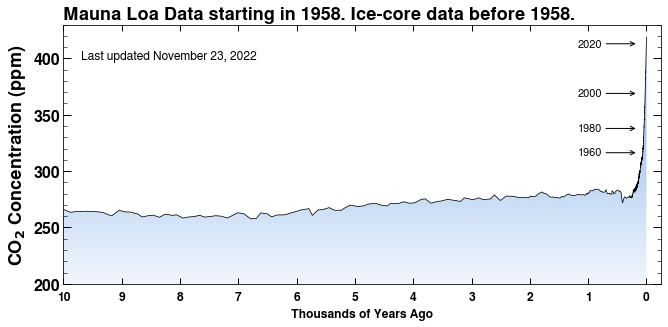

In [51]:
# create a figure container
fig = plt.figure()

# Set axes
# Add padding for exterior plot text
ax = plt.axes([0.11, 0.12, 0.83, 0.54])


# ------------------------------------
# Set properties to use for matplotlib
# ------------------------------------

set_matplotlib_properties()

# ------------------------
# Add gradient under curve
# ------------------------

# The gradient is a guide to the eye

# Set gradient limits to the data limits

# Reverse the order of the arrays for the gradient to plot left to right
# This order is necessary for the gradient to plot properly
combined_years_before_now =  np.flipud(combined_years_before_now)
combined_co2 = np.flipud(combined_co2)

# Plot gradient starting at start of data (want negative value of max years back)
data_start_date = -max(combined_years_before_now)
data_end_date = -min(combined_years_before_now)

area_color = '#73a7e6'

gradient_fill(-combined_years_before_now, combined_co2, fill_color=area_color, 
              xmin=data_start_date, ymin=ymin, xmax=data_end_date, ymax=ymax, 
              ax=ax, alpha_bottom=0.1, alpha=1.0)


# -------------
# Plot the data
# -------------

# Set plotting zorder above the gradient

# Plot years back in time (left of 0) so use negative of values
# Because want increasing years before now to appear farther left on x axis
ax.plot(-combined_years_before_now, combined_co2, '-', color='black', linewidth=0.75, zorder=5)

# -----------------------------------------------------
# Change xaxis to use date labels and not decimal dates
# -----------------------------------------------------
create_xtick_labels(ax, xmin, xmax)

# -------------------
# Set plot properties
# -------------------
set_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)

# ---------------
# Add date arrows
# ---------------
apply_arrow_annotations(todays_decimal, mlo_date, mlo_co2)

# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)

# --------------
# Add inset text
# --------------
inset_text = f'Last updated {todays_date_modyyr}'
add_inset_label(ax, inset_text)

# ------------
# Save graphic
# ------------
fig = plt.gcf()

save_graphic(fig, pdf_file, png_file)


plt.show()

## **Download PDF & PNG files of the graphic**

The download button only works when the notebook is run with Google Colab

If the notebook is run on a local machine, the graphics are inside the plots directory

In [52]:
def download_files(ev):
    files.download(png_file)
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())